In [ ]:
!pip install -q sdv diffprivlib

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

from sklearn.model_selection import train_test_split

from sdv.single_table import GaussianCopulaSynthesizer
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

from diffprivlib.mechanisms import Laplace




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.6/196.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
def carica_dataset():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    df = pd.read_csv(url, header=None)
    df.columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
                  'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
    print("Dataset caricato da GitHub")
    return df

#TODO non sono sicura che serva
def preprocessa_dataset(df):
    cols_missing = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']
    df[cols_missing] = df[cols_missing].replace(0, np.nan)
    df[cols_missing] = df[cols_missing].fillna(df[cols_missing].median())
    return df

# GENERAZIONE DATI SINTETICI (NO PRIVACY) NOE
def synthetic_no_privacy(df, privacy="none", epsilon=1.0):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)
    model = CTGANSynthesizer(
      metadata,
      epochs=2000,
      batch_size=500,
      generator_dim=(256, 256, 256),
      discriminator_dim=(256, 256),
      verbose=True
    )
    model.fit(df)
    # Genera dati sintetici
    synthetic= model.sample(num_rows=len(df))
    return synthetic, metadata


#Gio -------

def correggi_valori(df_synth, df_real):
    df_corr = df_synth.copy()

    # Colonne intere
    int_cols = ['age', 'pregnancies', 'outcome']
    for col in int_cols:
        vmin = df_real[col].min()
        vmax = df_real[col].max()
        df_corr[col] = df_corr[col].round().astype(int).clip(vmin, vmax)

    # Colonne continue
    cont_cols = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree']
    for col in cont_cols:
        vmin = df_real[col].min()
        vmax = df_real[col].max()
        df_corr[col] = df_corr[col].clip(vmin, vmax)

    return df_corr

def add_dp_noise(series, epsilon=1.0):
    sensitivity = series.max() - series.min()
    mech = Laplace(epsilon=epsilon, sensitivity=sensitivity)
    noisy = series.apply(lambda x: mech.randomise(x))
    return noisy

def genera_dataset_sintetico(df_real, privacy_level='moderate'):
    print(f"\nGenerazione dataset sintetico - livello privacy: {privacy_level}")
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df_real)
    ctgan = CTGANSynthesizer(metadata, epochs=200)
    ctgan.fit(df_real)
    df_synth = ctgan.sample(len(df_real))

    # Rumore DP
    if privacy_level == 'moderate':
        epsilon = 1.0
        for col in df_synth.select_dtypes(include=[np.number]).columns:
            df_synth[col] = add_dp_noise(df_synth[col], epsilon)
    elif privacy_level == 'strong':
        epsilon = 0.1
        for col in df_synth.select_dtypes(include=[np.number]).columns:
            df_synth[col] = add_dp_noise(df_synth[col], epsilon)

    # Correzione valori fuori range usando dataset reale
    df_synth = correggi_valori(df_synth, df_real)

    return df_synth, metadata
#-----

df = carica_dataset()
#df = preprocessa_dataset(df)
train_df, holdout_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['outcome']) # Suddivido il dataset in train (70%) e holdout (30%)
#salva il csv
train_df.to_csv('train_df.csv', index=False)
holdout_df.to_csv('holdout_df.csv', index=False)

synthetic, metadata = synthetic_no_privacy(train_df)
# synthetic, metadata = genera_dataset_sintetico(train_df)
synthetic.to_csv('synthetic_data.csv', index=False)

Dataset caricato da GitHub


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Gen. (-3.05) | Discrim. (-0.08): 100%|██████████| 2000/2000 [00:59<00:00, 33.73it/s]


In [ ]:
# QUALITA' DEI DATI

diagnostic = run_diagnostic(
        real_data=df,
        synthetic_data=synthetic,
        metadata=metadata
    )

quality_report = evaluate_quality(
    df,
    synthetic,
    metadata
)

#quality_report.get_details('Column Shapes')

from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic,
    column_name='glucose',
    metadata=metadata
)

fig.show()

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 845.87it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 226.39it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 477.14it/s]|
Column Shapes Score: 85.14%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 222.05it/s]|
Column Pair Trends Score: 88.95%

Overall Score (Average): 87.05%



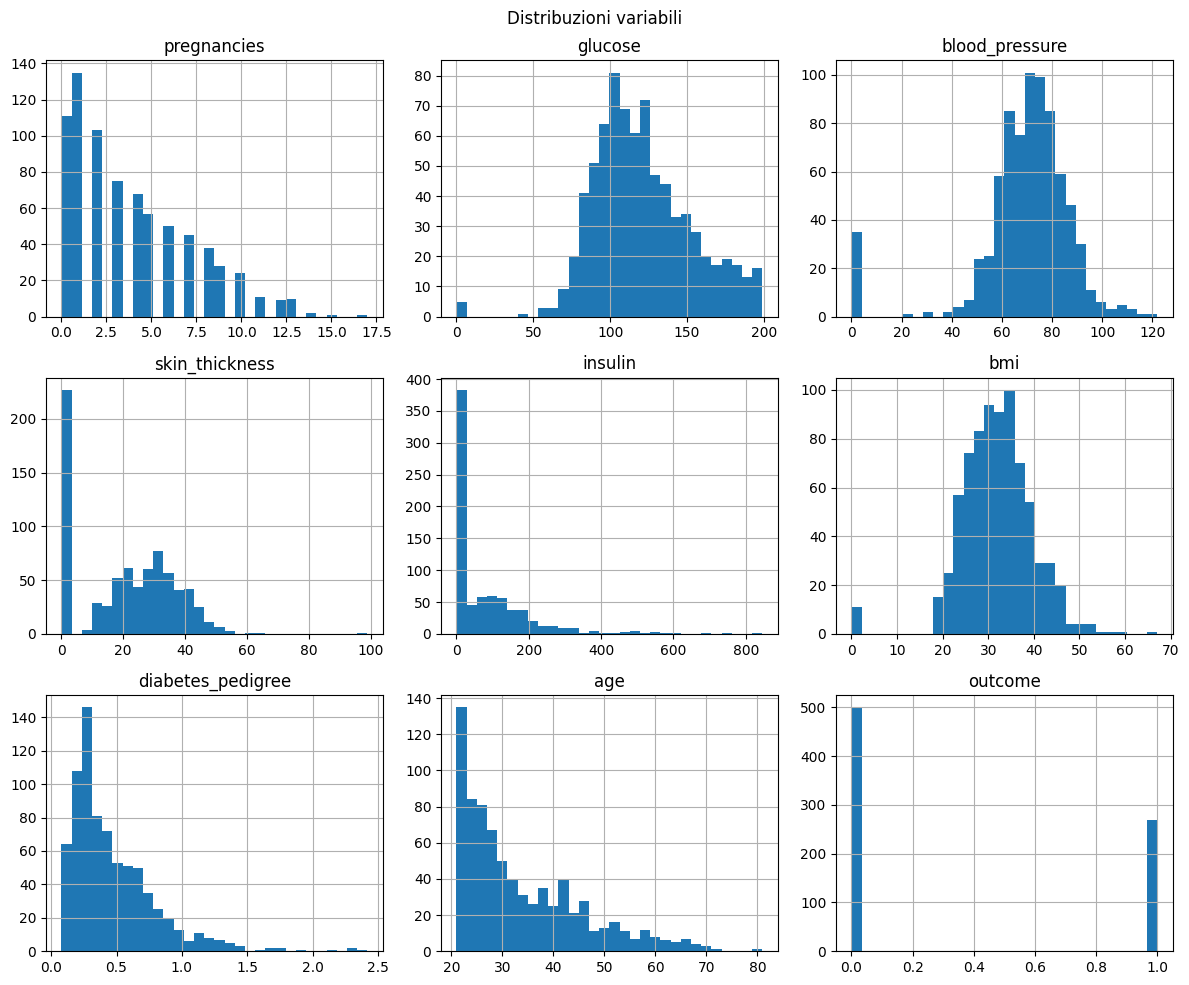

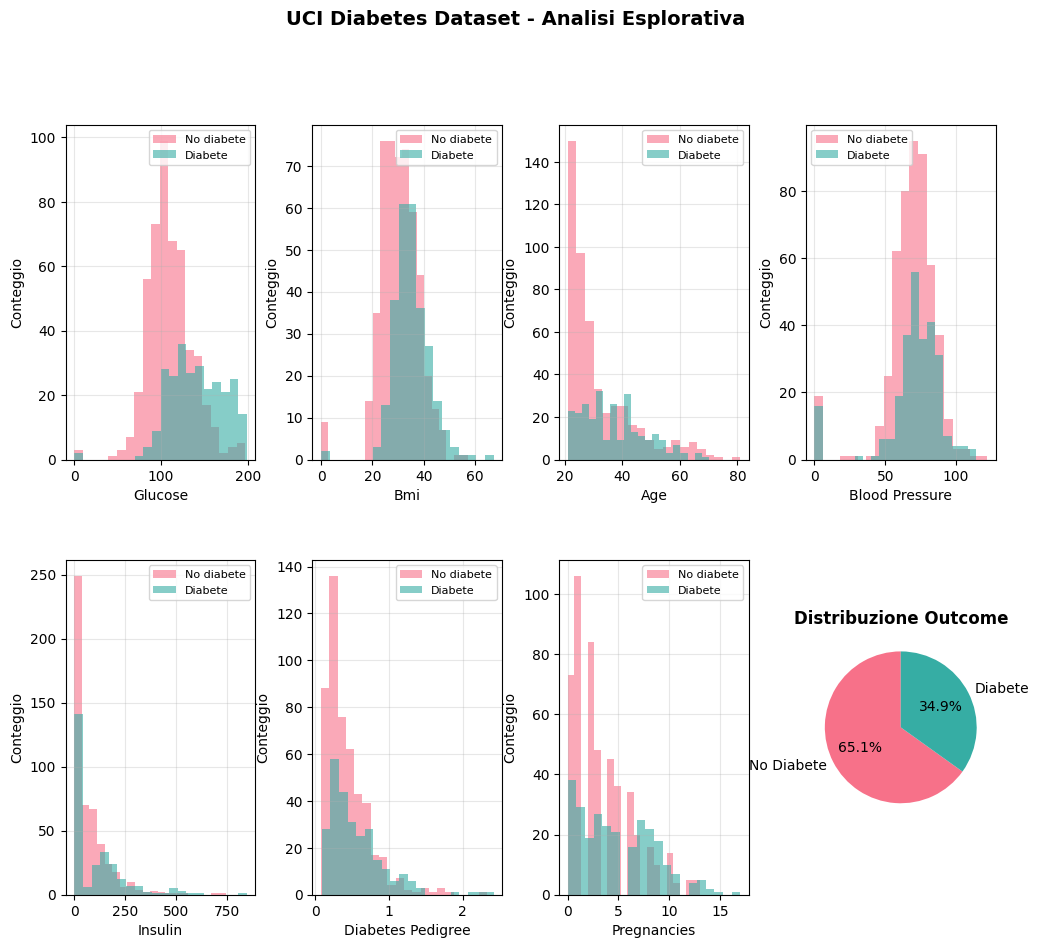

In [ ]:
# GRAFICI:

# Distribuzione delle variabili numeriche
def plot_distributions(df): #Noe
  df.hist(figsize=(12, 10), bins=30)
  plt.suptitle('Distribuzioni variabili')
  plt.tight_layout()
  plt.show()

def plot_distribution2(df): #Gio
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)
    color_palette = sns.color_palette("husl", 2)
    features_plot = ['glucose', 'bmi', 'age', 'blood_pressure', 'insulin', 'diabetes_pedigree', 'pregnancies']

    for i, feature in enumerate(features_plot):
        ax = fig.add_subplot(gs[i//4, i%4])
        df[df['outcome']==0][feature].hist(bins=20, alpha=0.6, color=color_palette[0], label='No diabete', ax=ax)
        df[df['outcome']==1][feature].hist(bins=20, alpha=0.6, color=color_palette[1], label='Diabete', ax=ax)
        ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
        ax.set_ylabel('Conteggio', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    ax = fig.add_subplot(gs[1, 3])
    outcome_counts = df['outcome'].value_counts()
    ax.pie(outcome_counts, labels=['No Diabete', 'Diabete'], autopct='%1.1f%%', colors=color_palette, startangle=90, textprops={'fontsize': 10})
    ax.set_title('Distribuzione Outcome', fontsize=12, fontweight='bold')
    plt.suptitle('UCI Diabetes Dataset - Analisi Esplorativa', fontsize=14, fontweight='bold', y=0.995)
    plt.show()

# Matrice di correlazione
def plot_correlation_matrix(dataset):
  corr = dataset.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr, annot=True, cmap='coolwarm')
  plt.title('Matrice di correlazione')
  plt.show()

plot_distributions(df)
plot_distribution2(df)